In [1]:
# importa os pacotes necessários
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

# Lendo imagem

(32, 32, 3)


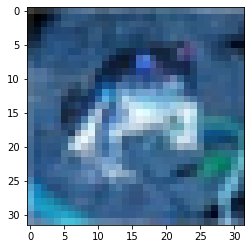

In [2]:
#funções de leitura das imagens
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return img#cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
img = read_image('kaggle/train/1.png')
print(img.shape)
plt.imshow(img)

# Descritor 1 - Histograma

((512,), (512,))

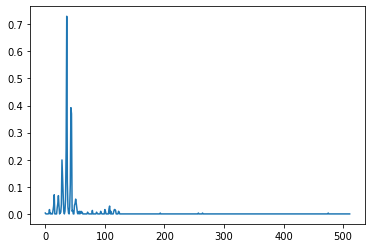

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # the flattened histogram as the feature vector
    hist = hist.flatten()
    
    #columns name
    columns = np.array(['hist_%03d'%(i+1) for i in range(len(hist))])
    
    return hist, columns
hist, cols1 = extract_color_histogram(img)
plt.plot(hist)
hist.shape, cols1.shape

# Descritor 2 - Feature Vector

((3072,), (3072,))

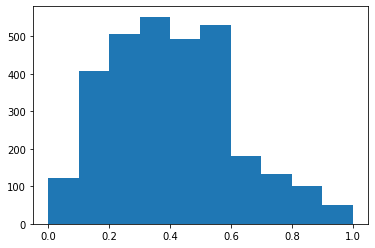

In [4]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    if img.shape[:2] != size:
        fvet = cv2.resize(image, size).flatten()
    else:
        fvet = image.flatten()
    fvet = fvet/255
    
    #columns name
    columns = np.array(['fvet_%03d'%(i+1) for i in range(len(fvet))])
    
    return fvet,columns

fvet, cols2 = image_to_feature_vector(img)
plt.hist(fvet)
fvet.shape, cols2.shape

# Descritor 3 - Hu Moments

In [5]:
def hu_moments(image, size=(32, 32)):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hmom = cv2.HuMoments(cv2.moments(img_gray)).flatten()
    cols = np.array(['humom_1','humom_2','humom_3','humom_4','humom_5','humom_6','humom_7'])
    return hmom,cols
hmom, cols3 = hu_moments(img)
print(hmom)
hmom.shape, cols3.shape

[ 1.37597983e-03  8.55818987e-09  1.99613546e-11  5.12474924e-12
  4.67974848e-23 -2.65526534e-16  2.22850951e-23]


((7,), (7,))

Ver depois 
http://wiki.icmc.usp.br/images/d/d7/Dip10_imagedescription-texture.pdf

# Junta Descritores

In [6]:
#Cria uma serie com descritores
def junta_descritores(descritores, colunas):
    serie = pd.Series()
    for d,c in zip(descritores, colunas):
        serie = serie.append(pd.Series(d, index=c))
    return serie

In [7]:
serie = junta_descritores([hist,fvet,hmom],[cols1,cols2,cols3])
print(serie.shape)
print(serie.head(3))
print(serie.tail(3))

(3591,)
hist_001    0.003214
hist_002    0.000000
hist_003    0.000000
dtype: float64
humom_5    4.679748e-23
humom_6   -2.655265e-16
humom_7    2.228510e-23
dtype: float64


# Pipeline

In [8]:
# retorna uma serie com os descritores
def pipeline1(file_path):
    
    img = read_image(file_path)
    
    #descritores
    hist, cols1 = extract_color_histogram(img)
    fvet, cols2 = image_to_feature_vector(img,size=(16, 16))
    hmom, cols3 = hu_moments(img)
    #...
    
    #junta
    serie = junta_descritores([hist,fvet,hmom],[cols1,cols2,cols3])
    
    return serie

In [9]:
def run_pipeline(n_images = 50000, folder = 'train'): 
    
    lista_series = list()
    df = pd.DataFrame()
    
    #para cada imagem 
    for i in range(n_images):
        if (i+1)%1000 == 0:
            print(i+1,'/',n_images)
            df = df.append(lista_series)
            lista_series = list()
            
        #adiciona linha na tabela
        file_path = os.path.join(os.path.join('kaggle',folder),str(i+1))+'.png'
        serie = pipeline1(file_path)
        lista_series.append(serie)
    
    if len(lista_series):
        df = df.append(lista_series)
    df = df.reset_index(drop = True).astype('float32')
    
    #normaliza
    df = (df - df.min())/(df.max() - df.min())
    
    #PCA
    print("PCA ...")
    pca = PCA(n_components=0.98)#98% da variância 
    principalComponents = pca.fit_transform(df)
    n_components = principalComponents.shape[1] 
    print(' ',n_components, 'componentes de',df.shape[1],'colunas')
    df_pca = pd.DataFrame(data = principalComponents,
                          columns = ['comp_%03d'%i for i in range(n_components)]).astype('float32')
    
    
    #salva
    print('Salvando ...')
    file_path = os.path.join('kaggle',folder)+'.csv'
    df.to_csv(file_path, index=False)
    file_path = os.path.join('kaggle',folder+'_pca')+'.csv'
    df_pca.to_csv(file_path, index=False)
    
    print('End')
    return df,df_pca

In [10]:
%%time
df,df_pca = run_pipeline()

1000 / 50000
2000 / 50000
3000 / 50000
4000 / 50000
5000 / 50000
6000 / 50000
7000 / 50000
8000 / 50000
9000 / 50000
10000 / 50000
11000 / 50000
12000 / 50000
13000 / 50000
14000 / 50000
15000 / 50000
16000 / 50000
17000 / 50000
18000 / 50000
19000 / 50000
20000 / 50000
21000 / 50000
22000 / 50000
23000 / 50000
24000 / 50000
25000 / 50000
26000 / 50000
27000 / 50000
28000 / 50000
29000 / 50000
30000 / 50000
31000 / 50000
32000 / 50000
33000 / 50000
34000 / 50000
35000 / 50000
36000 / 50000
37000 / 50000
38000 / 50000
39000 / 50000
40000 / 50000
41000 / 50000
42000 / 50000
43000 / 50000
44000 / 50000
45000 / 50000
46000 / 50000
47000 / 50000
48000 / 50000
49000 / 50000
50000 / 50000
PCA ...
  290 componentes de 1287 colunas
Salvando ...
End
CPU times: user 6min 57s, sys: 33.9 s, total: 7min 31s
Wall time: 7min 59s


In [11]:
print(df.shape)
df.head()

(50000, 1287)


,hist_001,hist_002,hist_003,hist_004,hist_005,hist_006,hist_007,hist_008,hist_009,hist_010,...,fvet_766,fvet_767,fvet_768,humom_1,humom_2,humom_3,humom_4,humom_5,humom_6,humom_7
0,0.003221,0.000000,0.000000,0.000000,0.000000,0.000000,0.003228,0.016071,0.000000,0.003473,...,0.219608,0.317647,0.447059,0.071065,0.000586,0.000493,0.000124,0.290060,0.492908,0.281908
1,0.007562,0.007663,0.022684,0.078495,0.022841,0.045888,0.098514,0.120741,0.000000,0.016306,...,0.525490,0.494118,0.529412,0.048714,0.000138,0.000956,0.000156,0.290060,0.492908,0.281909
2,0.000000,0.000000,0.026808,0.015902,0.000000,0.011621,0.042219,0.703259,0.005917,0.024776,...,0.317647,0.325490,0.301961,0.057842,0.000666,0.002769,0.002802,0.290069,0.492803,0.281925
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.184314,0.262745,0.286275,0.104606,0.000458,0.000204,0.000065,0.290060,0.492910,0.281908
4,0.011941,0.012101,0.202994,0.049582,0.030058,0.030194,0.053851,0.131086,0.009224,0.064374,...,0.309804,0.298039,0.282353,0.094153,0.002421,0.001660,0.000347,0.290059,0.492886,0.281909


In [12]:
print(df_pca.shape)
df_pca.head()

(50000, 290)


,comp_000,comp_001,comp_002,comp_003,comp_004,comp_005,comp_006,comp_007,comp_008,comp_009,...,comp_280,comp_281,comp_282,comp_283,comp_284,comp_285,comp_286,comp_287,comp_288,comp_289
0,-3.197660,1.381055,0.740043,2.345486,1.345046,0.292847,-0.320646,0.191596,-1.637430,0.573352,...,0.091306,0.168859,0.053704,-0.107979,-0.134570,0.036341,-0.027506,-0.060461,-0.008489,-0.032451
1,0.432848,-0.474345,2.986024,-0.357867,0.953658,0.585376,-0.342184,-0.177411,-1.300116,1.279692,...,0.012879,0.064904,-0.122059,-0.110912,-0.004185,0.053273,0.151464,-0.032301,-0.047744,0.075484
2,3.866156,-5.751686,-1.397291,-0.681969,1.236071,-1.105396,0.325054,-0.697993,0.270854,-0.565203,...,-0.082321,-0.102567,-0.106817,-0.061066,-0.044525,0.033918,0.071953,0.004957,0.054393,-0.110565
3,-5.177608,0.012106,0.538429,0.961400,0.426960,0.424047,-0.134329,0.168936,-0.718516,-0.185658,...,-0.022881,-0.053927,-0.069859,0.067906,-0.024674,0.015147,0.050277,0.032631,-0.014011,-0.001531
4,-1.303244,-2.490025,0.527267,-1.786173,0.141412,-0.108555,-2.791836,0.842301,-1.858630,-0.962537,...,0.018518,-0.038903,0.110861,0.084957,0.023974,-0.094583,-0.185005,-0.142309,0.017405,-0.035427


# Escolha do número de componentes do PCA

In [13]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(df)

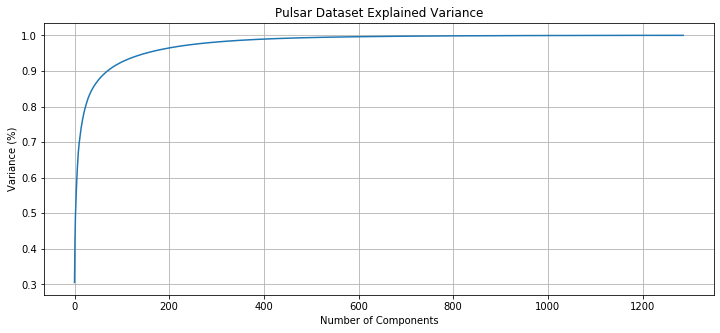

In [14]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.grid()
plt.show()

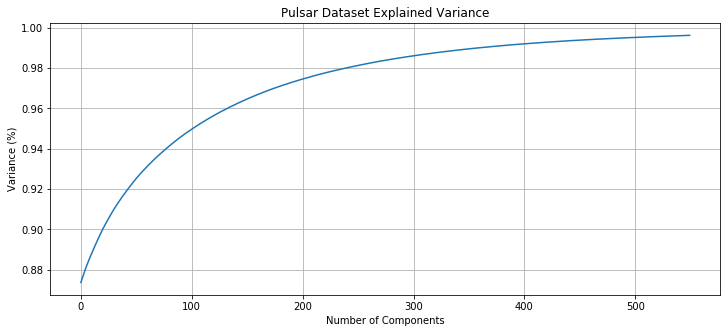

In [15]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)[50:600])
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.grid()
plt.show()

Escolhemos por não selecionar manualmente o número de componentes, mas utilizar um limiar de 98% da variância que possui uma boa representação dos dados. 